In [1]:
from google.colab import drive
drive.mount('/content/drive')
MODEL_PATH = "/content/drive/MyDrive/autoencoder.pth"

Mounted at /content/drive


In [2]:
# Install and import required libraries
!pip install torch torchvision opencv-python pillow numpy -q


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import zipfile
import shutil
import tempfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.1 MB/s eta 0:00:00


In [18]:
# Install and import required libraries
!pip install torch torchvision opencv-python pillow numpy -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import zipfile
import tempfile
import shutil

# Configuration
IMG_SIZE = 256  # Match Kaggle notebook resolution
BATCH_SIZE = 32
EPOCHS = 150  # Increased for better convergence
MODEL_PATH = "autoencoder_improved.pth"  # Model path

# File paths (already uploaded in Colab)
PERFECT_PARTS_ZIP = "/content/Single Angle Data Set.zip"  # Contains perfect parts for training

# Custom Dataset for Perfect Parts with Green Background Removal
class PerfectPartsDataset(Dataset):
    """Dataset for loading perfect parts with green background removal."""
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for root, _, files in os.walk(root_dir):
            for f in files:
                if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                    self.image_paths.append(os.path.join(root, f))

        if not self.image_paths:
            raise ValueError(f"No .jpg, .png, or .jpeg images found in {root_dir} or its subdirectories.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not load image at {img_path}")

        # Reduce brightness by 50
        image = cv2.convertScaleAbs(image, beta=-50)

        # Apply bilateral filter to reduce noise and glare
        image = cv2.bilateralFilter(image, 5, 50, 50)

        # Apply CLAHE to normalize lighting
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)
        lab = cv2.merge((l_clahe, a, b))
        image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Remove green background
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lower_green = np.array([35, 50, 50])
        upper_green = np.array([85, 255, 255])
        mask = cv2.inRange(hsv, lower_green, upper_green)
        image = cv2.bitwise_and(image, image, mask=255 - mask)

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)
        return image

# Perceptual Loss using VGG16
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        self.vgg_layers = vgg[:16].eval()  # Use first 16 layers for perceptual loss
        for param in self.vgg_layers.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x_vgg = self.vgg_layers(x)
        y_vgg = self.vgg_layers(y)
        return nn.functional.mse_loss(x_vgg, y_vgg)

# Autoencoder Model
class Autoencoder(nn.Module):
    """Autoencoder model with the same encoder and decoder as the Kaggle notebook."""
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Extract Zip File
def extract_zip(zip_path):
    """Extract the zip file to a temporary directory."""
    temp_dir = tempfile.mkdtemp()
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
    print(f"Extracted zip file to {temp_dir}")
    return temp_dir

# Train the Autoencoder (on perfect parts with augmentation)
def train_autoencoder(zip_path):
    """Train the autoencoder on perfect parts with green background removal and augmentation."""
    extracted_dir = extract_zip(zip_path)

    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE + 20, IMG_SIZE + 20)),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.1)),
        transforms.RandomRotation(degrees=5),
        transforms.ColorJitter(brightness=0.3, contrast=0.2),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.005),  # Add slight noise
    ])

    try:
        dataset = PerfectPartsDataset(root_dir=extracted_dir, transform=transform)
    except ValueError as e:
        print(f"Error: {e}")
        shutil.rmtree(extracted_dir)
        raise

    # Create a separate dataset for validation (without training transforms)
    val_dataset = PerfectPartsDataset(root_dir=extracted_dir, transform=None)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = Autoencoder()
    criterion_mse = nn.MSELoss()
    criterion_perceptual = PerceptualLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion_perceptual.to(device)

    # Validation: Use one image to monitor reconstruction quality
    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ])
    val_image = val_dataset[0]  # Get raw PIL Image
    print(f"Validation image type before transform: {type(val_image)}")
    val_image = val_transform(val_image).unsqueeze(0).to(device)
    print(f"Validation image type after transform: {type(val_image)}")

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss_mse = criterion_mse(outputs, batch)
            loss_perceptual = criterion_perceptual(outputs, batch)
            loss = 0.9 * loss_mse + 0.1 * loss_perceptual  # Adjusted weights
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        # Validation: Reconstruct and visualize the validation image
        if (epoch + 1) % 20 == 0:
            model.eval()
            with torch.no_grad():
                val_output = model(val_image)
            val_image_np = val_image.squeeze().cpu().permute(1, 2, 0).numpy()
            val_output_np = val_output.squeeze().cpu().permute(1, 2, 0).numpy()
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(val_image_np)
            plt.title("Original Validation Image")
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(val_output_np)
            plt.title(f"Reconstructed (Epoch {epoch+1})")
            plt.axis('off')
            plt.savefig(f"validation_epoch_{epoch+1}.png")
            plt.close()
            print(f"Validation image saved for epoch {epoch+1}")

        scheduler.step()

    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")

    # Clean up temporary directory
    shutil.rmtree(extracted_dir)

# Execute the Training
train_autoencoder(PERFECT_PARTS_ZIP)

Extracted zip file to /tmp/tmpxdiom6hr
Validation image type before transform: <class 'PIL.Image.Image'>
Validation image type after transform: <class 'torch.Tensor'>
Epoch 1/150, Loss: 0.433994, LR: 0.001000
Epoch 2/150, Loss: 0.387228, LR: 0.001000
Epoch 3/150, Loss: 0.323522, LR: 0.001000
Epoch 4/150, Loss: 0.312613, LR: 0.001000
Epoch 5/150, Loss: 0.311021, LR: 0.001000
Epoch 6/150, Loss: 0.301541, LR: 0.001000
Epoch 7/150, Loss: 0.296477, LR: 0.001000
Epoch 8/150, Loss: 0.294654, LR: 0.001000
Epoch 9/150, Loss: 0.291228, LR: 0.001000
Epoch 10/150, Loss: 0.289766, LR: 0.001000
Epoch 11/150, Loss: 0.285284, LR: 0.001000
Epoch 12/150, Loss: 0.287616, LR: 0.001000
Epoch 13/150, Loss: 0.276926, LR: 0.001000
Epoch 14/150, Loss: 0.282239, LR: 0.001000
Epoch 15/150, Loss: 0.283941, LR: 0.001000
Epoch 16/150, Loss: 0.274919, LR: 0.001000
Epoch 17/150, Loss: 0.263006, LR: 0.001000
Epoch 18/150, Loss: 0.267461, LR: 0.001000
Epoch 19/150, Loss: 0.257902, LR: 0.001000
Epoch 20/150, Loss: 0.262

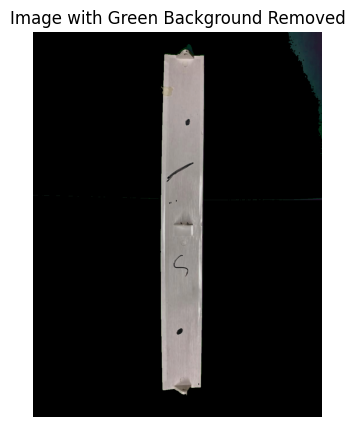

Error map - Min: 0.000000, Max: 0.552000, Mean: 0.017095


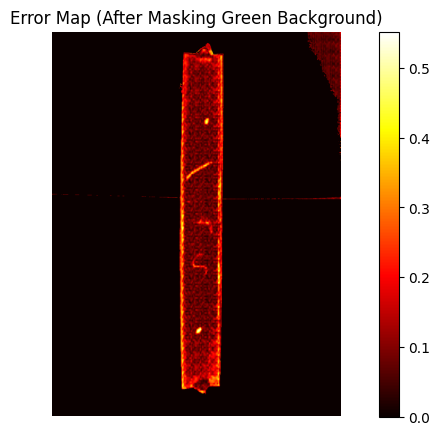

Threshold for anomaly detection: 0.223948


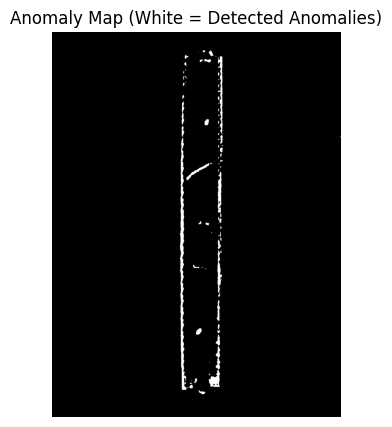

Number of contours detected: 80
Contour size: w=23, h=13, area=299, aspect_ratio=1.77
Contour size: w=3, h=3, area=9, aspect_ratio=1.00
Contour size: w=12, h=12, area=144, aspect_ratio=1.00
Contour size: w=6, h=4, area=24, aspect_ratio=1.50
Contour size: w=2, h=2, area=4, aspect_ratio=1.00
Contour size: w=10, h=16, area=160, aspect_ratio=1.60
Contour size: w=4, h=5, area=20, aspect_ratio=1.25
Contour size: w=37, h=57, area=2109, aspect_ratio=1.54
Contour size: w=2, h=2, area=4, aspect_ratio=1.00
Contour size: w=16, h=78, area=1248, aspect_ratio=4.88
Contour size: w=14, h=37, area=518, aspect_ratio=2.64
Contour size: w=9, h=11, area=99, aspect_ratio=1.22
Contour size: w=20, h=21, area=420, aspect_ratio=1.05
Contour size: w=6, h=18, area=108, aspect_ratio=3.00
Contour size: w=11, h=69, area=759, aspect_ratio=6.27
Contour size: w=2, h=3, area=6, aspect_ratio=1.50
Contour size: w=3, h=3, area=9, aspect_ratio=1.00
Contour size: w=4, h=1, area=4, aspect_ratio=4.00
Contour size: w=4, h=2, are

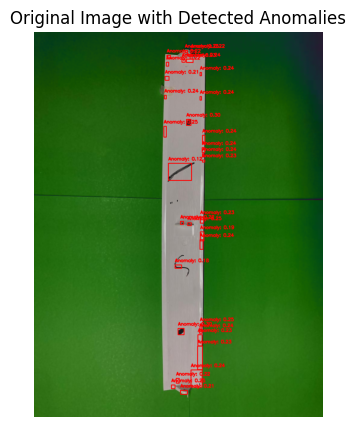

Annotated image saved to output_imperf1.jpg
Result summary saved to results_imperf1.txt


In [19]:
# Import required libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Configuration
IMG_SIZE = 256  # Match Kaggle notebook resolution
MIN_CONTOUR_SIZE = 1  # For smaller anomalies
MIN_CONTOUR_AREA = 50  # For smaller anomalies
MAX_ASPECT_RATIO = 5.0  # Relaxed to capture more anomalies
MODEL_PATH = "autoencoder_improved.pth"  # Updated to new model path

# File path (already uploaded in Colab)
TEST_IMAGE = "/content/imperf1.jpg"  # Defective image for testing

# Autoencoder Model (matches Kaggle notebook exactly)
class Autoencoder(nn.Module):
    """Autoencoder model with the same encoder and decoder as the Kaggle notebook."""
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Detect Anomalies and Localize with Bounding Boxes
def detect_anomalies(image_path, model_path=MODEL_PATH):
    """Detect anomalies in the defective image and localize them with bounding boxes."""
    model = Autoencoder()
    model.load_state_dict(torch.load(model_path))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ])
    orig_img = cv2.imread(image_path)
    if orig_img is None:
        raise ValueError(f"Could not load image at {image_path}")

    # Reduce brightness by 50
    orig_img = cv2.convertScaleAbs(orig_img, beta=-50)

    # Apply bilateral filter to reduce noise and glare with less smoothing
    orig_img = cv2.bilateralFilter(orig_img, 5, 50, 50)

    # Apply CLAHE to normalize lighting
    lab = cv2.cvtColor(orig_img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab = cv2.merge((l_clahe, a, b))
    img_normalized = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    img_normalized = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2RGB)

    # Create a copy for masking
    img_for_mask = img_normalized.copy()

    # Convert to HSV and mask out green background
    hsv = cv2.cvtColor(img_for_mask, cv2.COLOR_RGB2HSV)
    lower_green = np.array([35, 50, 50])  # Adjusted for green screen-like background
    upper_green = np.array([85, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    img_masked = cv2.bitwise_and(img_normalized, img_normalized, mask=255 - mask)

    # Debug: Visualize the masked image
    plt.figure(figsize=(10, 5))
    plt.imshow(img_masked)
    plt.title("Image with Green Background Removed")
    plt.axis('off')
    plt.show()

    img = Image.fromarray(img_masked)

    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        reconstructed = model(img_tensor)

    error = torch.abs(img_tensor - reconstructed).mean(dim=1).squeeze().cpu().numpy()
    error = cv2.resize(error, (orig_img.shape[1], orig_img.shape[0]))

    # Apply the mask to the error map to focus on the part
    error = cv2.bitwise_and(error, error, mask=255 - mask)

    # Debug: Print min, max, and mean of the error map
    print(f"Error map - Min: {error.min():.6f}, Max: {error.max():.6f}, Mean: {error.mean():.6f}")

    # Debug: Visualize the error map
    plt.figure(figsize=(10, 5))
    plt.imshow(error, cmap='hot')
    plt.title("Error Map (After Masking Green Background)")
    plt.colorbar()
    plt.axis('off')
    plt.show()

    # Apply Gaussian blur to smooth out noise
    error = cv2.GaussianBlur(error, (5, 5), 0)

    # Dynamic thresholding based on percentile
    threshold = np.percentile(error[np.nonzero(error)], 90)  # Lowered to 90th percentile
    print(f"Threshold for anomaly detection: {threshold:.6f}")
    anomaly_map = (error > threshold).astype(np.uint8) * 255

    # Debug: Display the anomaly map
    plt.figure(figsize=(10, 5))
    plt.imshow(anomaly_map, cmap='gray')
    plt.title("Anomaly Map (White = Detected Anomalies)")
    plt.axis('off')
    plt.show()

    # Find contours in the anomaly map
    contours, _ = cv2.findContours(anomaly_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    print(f"Number of contours detected: {len(contours)}")
    boxes = []
    anomaly_scores = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        aspect_ratio = max(w/h, h/w) if h != 0 else float('inf')
        print(f"Contour size: w={w}, h={h}, area={area}, aspect_ratio={aspect_ratio:.2f}")
        if (w > MIN_CONTOUR_SIZE and h > MIN_CONTOUR_SIZE and
            area > MIN_CONTOUR_AREA and area < orig_img.shape[0] * orig_img.shape[1] * 0.5 and
            aspect_ratio < MAX_ASPECT_RATIO):
            boxes.append((x, y, x + w, y + h))
            region_error = error[y:y+h, x:x+w].mean()
            anomaly_scores.append(region_error)

    anomaly_scores = np.array(anomaly_scores)
    print(f"Anomaly scores: {anomaly_scores}")

    if len(boxes) == 0:
        print("No anomalies detected (no contours passed the filters).")
    else:
        print(f"Detected {len(boxes)} potential anomalies.")

    # Draw bounding boxes for all detected contours
    for (box, score) in zip(boxes, anomaly_scores):
        x1, y1, x2, y2 = box
        label = f"Anomaly: {score:.2f}"
        cv2.rectangle(orig_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(orig_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Display the result
    plt.figure(figsize=(15, 5))
    plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Detected Anomalies")
    plt.axis('off')
    plt.show()

    output_image_path = "output_" + os.path.basename(image_path)
    cv2.imwrite(output_image_path, orig_img)
    print(f"Annotated image saved to {output_image_path}")

    output_result_path = "results_" + os.path.basename(image_path).replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt')
    with open(output_result_path, 'w') as f:
        f.write("Anomaly Detection Results\n")
        f.write("------------------------\n")
        f.write("Timestamp: 10:06 PM PKT, Sunday, June 01, 2025\n")
        f.write("Image: " + os.path.basename(image_path) + "\n")
        f.write("------------------------\n")
        f.write("ID | X1 | Y1 | X2 | Y2 | Area | Confidence Score\n")
        f.write("-----------------------------------------------\n")
        for i, (box, score) in enumerate(zip(boxes, anomaly_scores), 1):
            x1, y1, x2, y2 = box
            area = (x2 - x1) * (y2 - y1)
            f.write(f"{i}  | {x1} | {y1} | {x2} | {y2} | {area} | {score:.2f}\n")
    print(f"Result summary saved to {output_result_path}")

    return orig_img

# Execute the Testing
result_img = detect_anomalies(TEST_IMAGE)